In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import os

2025-05-20 16:03:27.204383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pl = pd.read_csv('/home/ryan/Downloads/pd_1747687111.csv')
po = pd.read_csv('/home/ryan/Downloads/pd_1747687187.csv')

/tmp/ipykernel_6768/2323238381.py:1: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  pl = pd.read_csv('/home/ryan/Downloads/pd_1747687111.csv')
/tmp/ipykernel_6768/2323238381.py:2: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  po = pd.read_csv('/home/ryan/Downloads/pd_1747687187.csv')


In [3]:
pl = pl.drop(pl.index[-6:])
pl['date'] = pd.to_datetime(pl['#date+time'])
po = po.drop(po.index[-6:])
po['date'] = pd.to_datetime(po['#date+time'])
pl = pl.drop(columns=['#date+time'])
po = po.drop(columns=['#date+time'])
main = pd.merge(pl, po, on='date', how='inner')
main.columns = ['pl_pwl','pl_bwl','pl_wsd','pl_wdr','date','po_pwl','po_bwl','po_wsd','po_wdr']
main = main.dropna().reset_index(drop=True)
main['pl_wdr'] = pd.to_numeric(main['pl_wdr'], errors='coerce')
main['pl_wsd'] = pd.to_numeric(main['pl_wsd'], errors='coerce')
main['po_wdr'] = pd.to_numeric(main['po_wdr'], errors='coerce')
main['po_wsd'] = pd.to_numeric(main['po_wsd'], errors='coerce')

main


,pl_pwl,pl_bwl,pl_wsd,pl_wdr,date,po_pwl,po_bwl,po_wsd,po_wdr
0,-0.072,0.408,5.6,268.0,2011-10-19 20:54:00,-0.057,0.667,7.4,317.0
1,-0.081,0.450,4.6,275.0,2011-10-19 21:00:00,-0.046,0.670,7.4,317.0
2,-0.087,0.448,4.6,272.0,2011-10-19 21:06:00,-0.048,0.670,6.3,324.0
3,-0.088,0.441,7.2,254.0,2011-10-19 21:12:00,-0.043,0.669,6.6,319.0
4,-0.081,0.441,6.0,258.0,2011-10-19 21:18:00,-0.050,0.666,5.9,323.0
...,...,...,...,...,...,...,...,...,...
428504,0.308,0.784,4.2,110.0,2017-01-01 23:30:00,0.340,0.453,2.1,121.0
428505,0.311,0.788,4.2,112.0,2017-01-01 23:36:00,0.346,0.454,2.5,106.0
428506,0.312,0.790,4.2,112.0,2017-01-01 23:42:00,0.345,0.455,3.0,111.0
428507,0.319,0.796,4.1,111.0,2017-01-01 23:48:00,0.349,0.457,3.0,113.0


In [4]:
def wind_to_uv(speed, direction_deg):
    # Convert to radians
    direction_rad = np.deg2rad(direction_deg)

    # U = -speed * sin(direction), V = -speed * cos(direction)
    # This converts FROM meteorological TO Cartesian
    u = -speed * np.sin(direction_rad)
    v = -speed * np.cos(direction_rad)
    return u, v

main[['u_station_pl', 'v_station_pl']] = pd.DataFrame(
    np.column_stack(wind_to_uv(main['pl_wsd'], main['pl_wdr'])), 
    index=main.index
)

main[['u_station_po', 'v_station_po']] = pd.DataFrame(
    np.column_stack(wind_to_uv(main['po_wsd'], main['po_wdr'])), 
    index=main.index
)


In [5]:
main = main.drop(columns=['pl_wsd', 'po_wsd', 'pl_wdr', 'po_wdr'])
main

,pl_pwl,pl_bwl,date,po_pwl,po_bwl,u_station_pl,v_station_pl,u_station_po,v_station_po
0,-0.072,0.408,2011-10-19 20:54:00,-0.057,0.667,5.596589,0.195437,5.046788,-5.412017
1,-0.081,0.450,2011-10-19 21:00:00,-0.046,0.670,4.582496,-0.400916,5.046788,-5.412017
2,-0.087,0.448,2011-10-19 21:06:00,-0.048,0.670,4.597198,-0.160538,3.703047,-5.096807
3,-0.088,0.441,2011-10-19 21:12:00,-0.043,0.669,6.921084,1.984589,4.329990,-4.981083
4,-0.081,0.441,2011-10-19 21:18:00,-0.050,0.666,5.868886,1.247470,3.550709,-4.711950
...,...,...,...,...,...,...,...,...,...
428504,0.308,0.784,2017-01-01 23:30:00,0.340,0.453,-3.946709,1.436485,-1.800051,1.081580
428505,0.311,0.788,2017-01-01 23:36:00,0.346,0.454,-3.894172,1.573348,-2.403154,0.689093
428506,0.312,0.790,2017-01-01 23:42:00,0.345,0.455,-3.894172,1.573348,-2.800741,1.075104
428507,0.319,0.796,2017-01-01 23:48:00,0.349,0.457,-3.827680,1.469309,-2.761515,1.172193


In [6]:
features = ['po_pwl', 'po_bwl', 'u_station_po', 'v_station_po']
main[features] = main[features].apply(pd.to_numeric, errors='coerce')
main['pl_pwl'] = pd.to_numeric(main['pl_pwl'], errors='coerce')
print(main[features].dtypes)
print(main['pl_pwl'].dtype)

data_array = main[features + ['pl_pwl']].to_numpy()
window_size = 10
n_samples = len(data_array) - window_size

X = np.empty((n_samples, window_size * len(features)), dtype=np.float32)
y = np.empty(n_samples, dtype=np.float32)

for i in range(n_samples):
    window = data_array[i:i+window_size, :-1].flatten()
    target = data_array[i+window_size, -1]  # still predict 'pl_pwl'
    if not np.isnan(window).any() and not np.isnan(target):
        X[i] = window
        y[i] = target
    else:
        X[i] = np.nan
        y[i] = np.nan

# Filter valid samples
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X = X[mask]
y = y[mask]

po_pwl          float64
po_bwl          float64
u_station_po    float64
v_station_po    float64
dtype: object
float64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(40,)),  # changed from 80 → 40
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    verbose=1
)

# Evaluate on test set
loss, mae = model.evaluate(X_test, y_test)
print(f"\nTest MSE: {loss:.4f}, MAE: {mae:.4f}")

2025-05-20 16:03:35.633598: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-20 16:03:38.891239: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-20 16:03:38.891318: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-20 16:03:38.892234: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-20 16:03:38.892342: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

Epoch 1/50


I0000 00:00:1747775021.256593    7300 service.cc:146] XLA service 0x757954005540 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747775021.256629    7300 service.cc:154]   StreamExecutor device (0): Radeon RX 7900 GRE, AMDGPU ISA version: gfx1100
2025-05-20 16:03:41.285262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  26/2118 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1092 - mae: 0.2572    

I0000 00:00:1747775023.466020    7300 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2118/2118 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0098 - mae: 0.0578 - val_loss: 0.0040 - val_mae: 0.0351
Epoch 2/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0027 - mae: 0.0349 - val_loss: 0.0047 - val_mae: 0.0345
Epoch 3/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0062 - mae: 0.0345 - val_loss: 0.0062 - val_mae: 0.0324
Epoch 4/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0034 - mae: 0.0332 - val_loss: 0.0124 - val_mae: 0.0324
Epoch 5/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0147 - mae: 0.0326 - val_loss: 0.0121 - val_mae: 0.0325
Epoch 6/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0018 - mae: 0.0316 - val_loss: 0.0044 - val_mae: 0.0325
Epoch 7/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0034 - mae: 0.0317 - val_loss: 0.0082 - val_mae: 0.0318
Epoch 8/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0036 - mae: 0.0314 - val_loss: 0.0040 - val_mae: 0.0315
Epoch 9/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/s

In [14]:
model.save('/home/ryan/Documents/CBI/3D_flags/model1_PLPO.keras') 

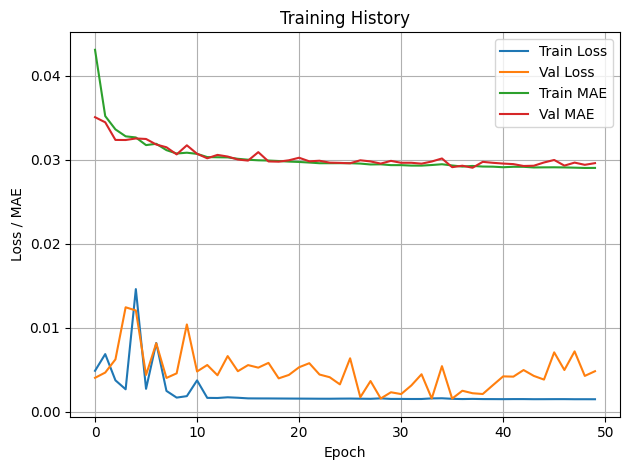

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss / MAE")
plt.grid(True)
plt.tight_layout()
plt.show()


2648/2648 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


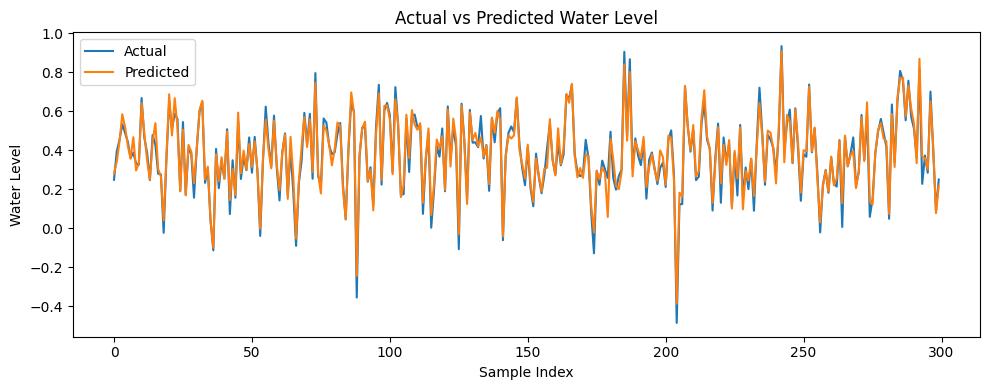

In [9]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 4))
plt.plot(y_test[:300], label='Actual')
plt.plot(y_pred[:300], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Water Level")
plt.xlabel("Sample Index")
plt.ylabel("Water Level")
plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")


R²: 0.9621


Testing with current inputs

In [15]:
features = ['po_pwl', 'po_bwl', 'u_station_po', 'v_station_po']
X = main[features].to_numpy(dtype=np.float32)
y = main['pl_pwl'].to_numpy(dtype=np.float32)
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X = X[mask]
y = y[mask]


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Simple MLP
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=128)

# Evaluate
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MSE: {loss:.4f}, MAE: {mae:.4f}")


Epoch 1/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0244 - mae: 0.0738 - val_loss: 0.0043 - val_mae: 0.0528
Epoch 2/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0041 - mae: 0.0512 - val_loss: 0.0042 - val_mae: 0.0519
Epoch 3/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0047 - mae: 0.0512 - val_loss: 0.0058 - val_mae: 0.0510
Epoch 4/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0059 - mae: 0.0508 - val_loss: 0.0061 - val_mae: 0.0506
Epoch 5/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0072 - mae: 0.0507 - val_loss: 0.0054 - val_mae: 0.0511
Epoch 6/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0098 - mae: 0.0506 - val_loss: 0.0042 - val_mae: 0.0507
Epoch 7/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0040 - mae: 0.0504 - val_loss: 0.0055 - val_mae: 0.0514
Epoch 8/50
2121/2121 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0127 - mae: 0.0509 - val_loss: 0.0042 - val_mae: 0.0509
Epoch 9/50
2121/2121 ━━━━━━━━━━━━━━━━━━

2651/2651 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


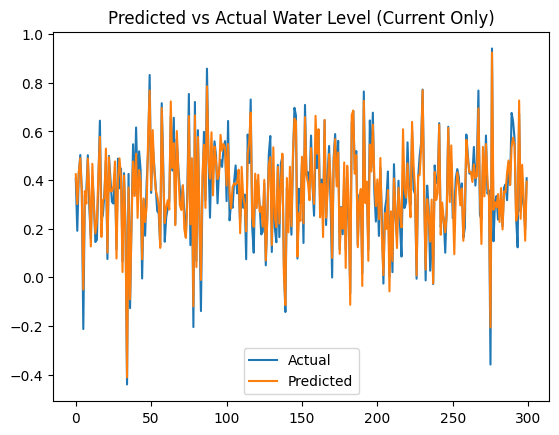

In [17]:
y_pred = model.predict(X_test).flatten()

import matplotlib.pyplot as plt
plt.plot(y_test[:300], label='Actual')
plt.plot(y_pred[:300], label='Predicted')
plt.legend()
plt.title("Predicted vs Actual Water Level (Current Only)")
plt.show()


In [18]:
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")


R²: 0.9070
